In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pygad
import torch
import pickle
import json
import pandas as pd
import numpy as np
from modules.functions import data_generator_vec, check_cuda
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from modules.trained_models import get_uts_without_grain


In [3]:
model_path = 'saved_models'
if os.path.exists(os.path.join(model_path, 'GAN_generator.pt')):
    generator = torch.jit.load(os.path.join(model_path, 'GAN_generator.pt'), map_location='cpu')
else:
    print('train model first!')

el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y.pkl','rb') as fid:
    uts_scaler = pickle.load(fid)

with open('misc/starting_comp.json','r') as fid:
    json_dict = json.load(fid)

## Candidate from generated ensemble

In [4]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')

latent_dim = 4

In [9]:
desired_uts = np.array(json_dict['start_uts']).reshape(-1,1).astype('float32')
scaled_desired_uts = uts_scaler.transform(desired_uts)
def ga_inputs(N, z_dim = latent_dim):
    #prop = torch.from_numpy(scaled_desired_uts)*torch.ones((N,1))
    noise = torch.from_numpy(noise_sampler(N,z_dim))
    return noise

desired_output = np.array(json_dict['start_comp'])

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
def fitness_func(solution, solution_idx):
    solution = torch.from_numpy(solution.reshape(-1,latent_dim).astype('float32'))
    prop_input = torch.from_numpy(scaled_desired_uts*np.ones((solution.shape[0],1)).astype('float32'))
    with torch.no_grad():
        output = generator(solution,prop_input)
    #idx = np.argwhere(np.array(json_dict['start_comp'])==0)
    #output[:,idx] = 0
    #weights = np.abs(output - desired_output)
    distance = mean_absolute_error(output.flatten(),desired_output.flatten())
    fitness = 1/distance #- (1-np.sum(output))
    return fitness

In [20]:
fitness_function = fitness_func

num_generations = 1000
num_parents_mating = 2

sol_per_pop = 20
num_genes = latent_dim

initial_population = ga_inputs(1000)

init_range_low = -2
init_range_high = 5

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "adaptive"
mutation_probability = (0.3,0.05)
mutation_percent_genes = (20,5)

In [21]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       mutation_probability=mutation_probability,
                       initial_population=initial_population)
ga_instance.run()

/noether/s0/aqd5773/anaconda3/envs/candidate_generation/lib/python3.10/site-packages/pygad/pygad.py:526: UserWarning: The percentage of genes to mutate (20) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate ({mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes[idx], mutation_num=mutation_num_genes[idx]))
/noether/s0/aqd5773/anaconda3/envs/candidate_generation/lib/python3.10/site-packages/pygad/pygad.py:526: UserWarning: The percentage of genes to mutate (5) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, p

In [22]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()

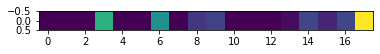

In [23]:
solution = torch.from_numpy(solution.reshape(-1,latent_dim).astype('float32'))
prop_input = torch.from_numpy(scaled_desired_uts*np.ones((solution.shape[0],1)).astype('float32'))
out = generator(solution,prop_input)
plt.imshow(out.to('cpu').detach().numpy())

In [27]:
out[out>5e-2]

tensor([0.2086, 0.1650, 0.0523, 0.0644, 0.0689, 0.0692, 0.3263],
       grad_fn=<IndexBackward0>)

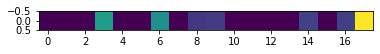

In [25]:
plt.imshow(np.array(json_dict['start_comp']).reshape(1,-1))

In [59]:
import pymatgen.core as mg
def decode(vec, elem_list, thresh=0.05):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    comp = ''
    for i, x in enumerate(vec):
        if x >= thresh:
            comp += elem_list[i] + '{:.2f} '.format(x)
    return mg.Composition(comp)
decode(np.array(json_dict['start_comp']), elem_list=el_list)

Comp: Hf0.18 Zr0.07 Ti0.07 Nb0.06 Cr0.2 Mo0.06 W0.36

In [55]:
el_list

array(['Al', 'C', 'Co', 'Cr', 'Cu', 'Fe', 'Hf', 'Mn', 'Mo', 'Nb', 'Ni',
       'Si', 'Sn', 'Ta', 'Ti', 'V', 'Zr', 'W'], dtype='<U2')

## A8/A10- composition

In [4]:
comps = ['Nb6Mo3W27Zr30Ti30V3','Zr0.17Ti0.03Nb0.47V0.13Mo0.13W0.07','Nb27.8Mo20.3W6.2Zr15.1Ti6.5V24.1']
dset = data_generator_vec(comps, el_list=el_list)
desired_outputs = dset.real_data
desired_utss = [get_uts_without_grain(x.reshape(1,-1)) for x in desired_outputs]
scaled_desired_utss = [uts_scaler.transform(x) for x in desired_utss]

In [6]:
desired_utss

[array([[0.26486555]], dtype=float32),
 array([[0.2959586]], dtype=float32),
 array([[0.16501693]], dtype=float32)]

In [5]:
[get_uts_without_grain(x.reshape(1,-1), t = 298) for x in desired_outputs]

[array([[1.1306597]], dtype=float32),
 array([[1.172805]], dtype=float32),
 array([[1.0545845]], dtype=float32)]

/noether/s0/aqd5773/anaconda3/envs/candidate_generation/lib/python3.10/site-packages/pygad/pygad.py:526: UserWarning: The percentage of genes to mutate (20) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  if not self.suppress_warnings: warnings.warn("The percentage of genes to mutate ({mutation_percent}) resutled in selecting ({mutation_num}) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).\nIf you do not want to mutate any gene, please set mutation_type=None.".format(mutation_percent=mutation_percent_genes[idx], mutation_num=mutation_num_genes[idx]))
/noether/s0/aqd5773/anaconda3/envs/candidate_generation/lib/python3.10/site-packages/pygad/pygad.py:526: UserWarning: The percentage of genes to mutate (5) resutled in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, p

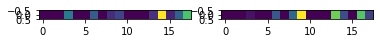

In [60]:
fig,ax = plt.subplots(1,2)
solution_list = []
for i, d in enumerate(desired_outputs):
    desired_output = d
    scaled_desired_uts = scaled_desired_utss[i]
    ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       mutation_probability=mutation_probability,
                       initial_population=initial_population)
    ga_instance.run()
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    solution = torch.from_numpy(solution.reshape(-1,latent_dim).astype('float32'))
    prop_input = torch.from_numpy(scaled_desired_uts*np.ones((solution.shape[0],1)).astype('float32'))
    out = generator(solution,prop_input)
    ax[i].imshow(out.to('cpu').detach().numpy())  
    solution_list.append(out)

Cr0.14 Hf0.1 Nb0.07 Ti0.34 Zr0.11 W0.25
Hf0.08 Mo0.09 Nb0.28 Ta0.22 Ti0.07 Zr0.21 W0.05


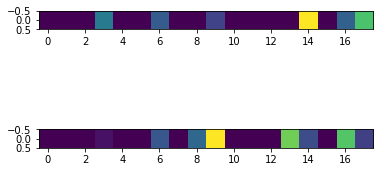

In [65]:
fig, ax = plt.subplots(2,1)
for i, d in enumerate(solution_list):
    d = d.to('cpu').detach().numpy().reshape(1,-1)
    ax[i].imshow(d)
    print(decode(d.flatten(), elem_list=el_list))

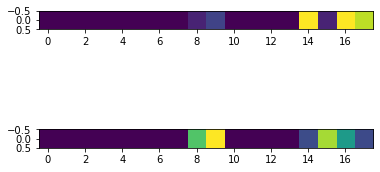

In [61]:
fig, ax = plt.subplots(2,1)
for i, d in enumerate(desired_outputs):
    ax[i].imshow(d.reshape(1,-1))

In [54]:
desired_outputs[1]

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.203,
       0.278, 0.   , 0.   , 0.   , 0.   , 0.065, 0.241, 0.151, 0.062],
      dtype=float32)

In [53]:
out

tensor([[3.1510e-13, 1.1890e-12, 1.8545e-12, 2.1290e-01, 1.8715e-12, 1.2450e-12,
         1.3482e-01, 3.7195e-13, 4.1126e-02, 9.8034e-02, 4.5603e-13, 2.1333e-12,
         6.3837e-13, 1.3208e-02, 2.4393e-02, 1.2802e-01, 8.0084e-02, 2.6741e-01]],
       grad_fn=<SoftmaxBackward0>)